# Fase 1: Clasificación del movimiento

**Descripción**\
Creación del pipline para clasificar el movimiento a partir de los cálculos estadísticos sobre los ángulos de las articulaciones. El pipeline contiene dos etapas:
1. Selección de varaibles con *SelectKBest*.
2. Algoritmo de clasificación.

**Entrada**
* ``medidasPerRepetition.csv``: archivo en formato CSV que contiene cálculos estadísticos sobre los ángulos por repetición de cada sujeto. Este es el archivo de salida de *leer_dataset.ipynb*.

**Salida**
* ``modelo_fase1_copy.sav``: archivo que guarda el pipeline completo de clasificación entrenado

******

In [1]:
# ---------- Importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# Scikit-learn (ML en python)
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import LearningCurveDisplay
## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
## Seleccion de variables
from sklearn.feature_selection import SelectKBest

#Pipeline
from imblearn.pipeline import Pipeline

# Guardar modelos
import joblib

import shap

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.drop(['CorrectLabel'], axis=1,
             inplace=True)
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,GestureName,RepetitionNumber,Duration,LeftShoulderAngle_standardDeviation,RightElbowVerticalAngle_standardDeviation,AnkleAngleRight_standardDeviation,RightArmpitAngle_standardDeviation,LeftWristAngle_standardDeviation,...,RightWristAngle_Kurtosis,RightWristVerticalAngle_Kurtosis,LeftArmpitAngle_Kurtosis,HipAngleLeft_Kurtosis,RightShoulderAngle_Kurtosis,KneeAngleLeft_Kurtosis,AnkleAngleLeft_Kurtosis,HipAngleRight_Kurtosis,KneeAngleRight_Kurtosis,LeftElbowVerticalAngle_Kurtosis
0,102,0,EFL,1,74,1.084519098105226,3.096724933697668,1.7357630825345078,4.022541954188054,1.3775399963780737,...,0.375606810920206,-1.4760492978515865,-0.9889825587727601,0.1950860066202451,2.216565125012212,-0.16696522726578022,-0.9218459378889565,-1.2130443787023806,-0.15931125809206037,-0.5550006329437256
1,102,0,EFL,2,64,0.6431764335319112,2.853584718762149,2.5199308063586257,5.1715427422131635,1.6271894060456007,...,1.1543998957163382,-1.555019663421444,-1.2938450639789785,-0.7888113108681654,0.3368673120556269,-1.05513197100136,-1.415922318356331,0.1663793296511078,-0.7952358950848302,-1.4878938973965026
2,102,0,EFL,3,58,0.872737827939969,3.8847928037185846,0.8997987242880856,6.45441632318698,1.6989747606490668,...,9.59080204890984,-1.5504431697089391,-1.2447151128330012,-0.9158241443474404,1.8525817425799684,-1.142127903113062,-1.2031165908034858,-1.3046791681113268,-0.6294624577289896,-1.5851672481922072
3,102,0,EFL,4,60,0.7791441029273922,3.158292603059735,1.140918640565108,5.178968725798659,2.016339624917005,...,4.1336237058292,-1.5568842937617597,-1.5331879897259844,-1.1852260550732128,1.0376150068514112,-1.2227381742521826,-1.515334441103624,0.005323712651228885,-0.8623099615734113,-1.6248831807491841
4,102,0,EFL,5,63,0.7524596863408536,2.965701560719748,1.9153757520588566,5.606323746225184,1.7008586220937247,...,5.640903309376775,-1.4175920291834356,-1.2588672287903098,-0.5924323757251706,1.3014582976032925,0.01031777600595607,-0.5172894066010225,-0.4846351691232118,-0.7211398634607731,-1.5222437388456367


****

## 1. Preprocesado

**1.1 Codificar variables**

In [3]:
# ------Preparar el dataset-------
df = df.drop(['GestureName'], axis=1)

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')
df.head()

,SubjectID,GestureLabel,RepetitionNumber,Duration,LeftShoulderAngle_standardDeviation,RightElbowVerticalAngle_standardDeviation,AnkleAngleRight_standardDeviation,RightArmpitAngle_standardDeviation,LeftWristAngle_standardDeviation,RightArmAngle_standardDeviation,...,RightWristAngle_Kurtosis,RightWristVerticalAngle_Kurtosis,LeftArmpitAngle_Kurtosis,HipAngleLeft_Kurtosis,RightShoulderAngle_Kurtosis,KneeAngleLeft_Kurtosis,AnkleAngleLeft_Kurtosis,HipAngleRight_Kurtosis,KneeAngleRight_Kurtosis,LeftElbowVerticalAngle_Kurtosis
0,102,0,1,74,1.084519,3.096725,1.735763,4.022542,1.377540,53.294387,...,0.375607,-1.476049,-0.988983,0.195086,2.216565,-0.166965,-0.921846,-1.213044,-0.159311,-0.555001
1,102,0,2,64,0.643176,2.853585,2.519931,5.171543,1.627189,49.408774,...,1.154400,-1.555020,-1.293845,-0.788811,0.336867,-1.055132,-1.415922,0.166379,-0.795236,-1.487894
2,102,0,3,58,0.872738,3.884793,0.899799,6.454416,1.698975,47.972135,...,9.590802,-1.550443,-1.244715,-0.915824,1.852582,-1.142128,-1.203117,-1.304679,-0.629462,-1.585167
3,102,0,4,60,0.779144,3.158293,1.140919,5.178969,2.016340,49.082401,...,4.133624,-1.556884,-1.533188,-1.185226,1.037615,-1.222738,-1.515334,0.005324,-0.862310,-1.624883
4,102,0,5,63,0.752460,2.965702,1.915376,5.606324,1.700859,49.404534,...,5.640903,-1.417592,-1.258867,-0.592432,1.301458,0.010318,-0.517289,-0.484635,-0.721140,-1.522244


**1.2 Dividir el dataset**

In [4]:
# ---- Dividir en test y train -----------
# Selecciona los datos de prueba (varios sujetos)
test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
            (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==302)] 

# Selecciona los datos de entrenamiento excluyendo los mismos sujetos
train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=302)]

# Caclular porcentajes
n_total = len(df)
print(f'Entrenamiento {(len(train_df)*100)/n_total}%. Prueba {(len(test_df)*100)/n_total}%')

# ------- Dividir en target y variables ---------
train_X = train_df.drop(['GestureLabel'], axis=1)
train_y=pd.DataFrame(train_df['GestureLabel']) 
test_X= test_df.drop(['GestureLabel'], axis=1) 
test_y =pd.DataFrame(test_df['GestureLabel'])

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()

Entrenamiento 76.71232876712328%. Prueba 23.28767123287671%


*****

## 2. Pipeline

**2.1 Malla de hiperparámetros**

In [5]:
#------------- Malla de hiperparametros ---------------
param_grid = [
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [6, 7, 8],
        'classifier__weights': ('uniform', 'distance'),
        'classifier__leaf_size': (3, 4, 5, 6, 8),
        'classifier__p': (1,2),
        'classifier__metric': ('minkowski', 'chebyshev')
    },
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__splitter': ['best', 'random'],
        'classifier__max_depth': [None, 40, 50, 60],
        'classifier__min_samples_split': [2, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 5, 7],
        'classifier__max_features': [None, 'sqrt', 'log2']
    },
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [SVC()],
        'classifier__C': [0.1, 0.2, 0.3],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [2, 3],
        'classifier__coef0': [0.0, 0.1, 0.2]
    },
    {
        'feature_selection__k': list(range(35, 60)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [300, 400, 500],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__max_depth': [None, 50, 60],
        'classifier__min_samples_split': [2, 3, 4],
        'classifier__min_samples_leaf': [1, 2, 5, 6],
    },
    {
        
        'feature_selection__k': list(range(35, 60)),
        'classifier': [MLPClassifier()],
        'classifier__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50)], 
        'classifier__activation': ['relu', 'tanh', 'logistic'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
        'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
    }
]

**2.2 Pipeline e hiperparametrización**

In [6]:
logo = LeaveOneGroupOut()
subject_ids = train_X['SubjectID'] # para los grupos
pipeline = Pipeline([
                     ('feature_selection', SelectKBest(k=50)),
                     ('classifier', KNeighborsClassifier(n_neighbors=2))
                    ])
random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1, n_iter=15,
                            scoring='f1_weighted', random_state=42)
random.fit(train_X, train_y, groups=subject_ids)

best_modelo = random.best_estimator_
print(best_modelo)

Pipeline(steps=[('feature_selection', SelectKBest(k=58)),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=60,
                                        min_samples_leaf=5,
                                        min_samples_split=20))])


**2.3 Evaluación del pipeline**

In [7]:
f1_score_train = best_modelo.score(train_X, train_y)
print(f'F1-score del conjunto de entrenamiento: {f1_score_train}')
print("Informe de clasificación (conjunto de prueba):")
prediction = best_modelo.predict(test_X)
print(classification_report(test_y, prediction)) 

F1-score del conjunto de entrenamiento: 0.9501050420168067
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        52
           1       0.82      0.77      0.79        70
           2       0.74      0.86      0.80        84
           3       0.54      0.67      0.60        57
           4       0.92      0.58      0.71        83
           5       0.74      0.86      0.80        43
           6       0.91      0.93      0.92        46
           7       0.62      0.77      0.69        60
           8       0.76      0.49      0.60        83

    accuracy                           0.74       578
   macro avg       0.75      0.76      0.74       578
weighted avg       0.76      0.74      0.73       578



* **Curva de apendizaje**

<Figure size 600x400 with 0 Axes>

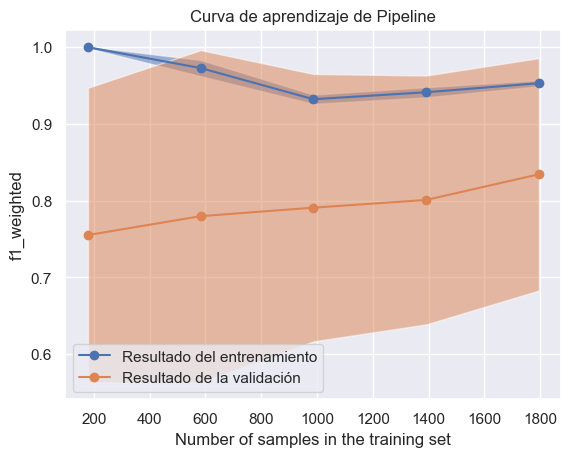

In [8]:
plt.figure(figsize=(6,4))
LearningCurveDisplay.from_estimator(best_modelo, 
                                    X=train_X,
                                    y=train_y,
                                    groups=subject_ids,
                                    cv=logo,
                                    score_type="both",
                                    n_jobs=4,
                                    line_kw={"marker": "o"},
                                    std_display_style="fill_between",
                                    score_name="f1_weighted"
                                )
    
plt.legend(["Resultado del entrenamiento", "Resultado de la validación"])
plt.title(f"Curva de aprendizaje de {random.estimator.__class__.__name__}")
plt.show()

* **Matriz de confusión**

Text(47.25, 0.5, 'True labels')

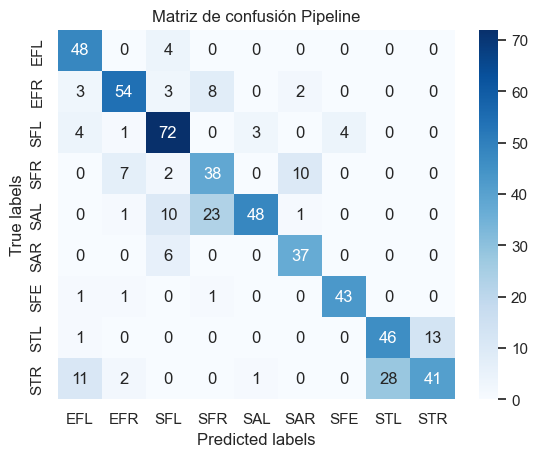

In [9]:
cm = confusion_matrix(test_y, prediction)
cm_df = pd.DataFrame(cm,
                    index = ['EFL','EFR','SFL', 'SFR', 'SAL',
                            'SAR', 'SFE', 'STL', 'STR'], 
                    columns = ['EFL','EFR','SFL', 'SFR', 'SAL',
                            'SAR', 'SFE', 'STL', 'STR'])
ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
ax.set_title(f'Matriz de confusión {best_modelo.__class__.__name__}')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

PermutationExplainer explainer: 579it [01:01,  7.34it/s]                         


<Axes: xlabel='SHAP value (impact on model output)'>

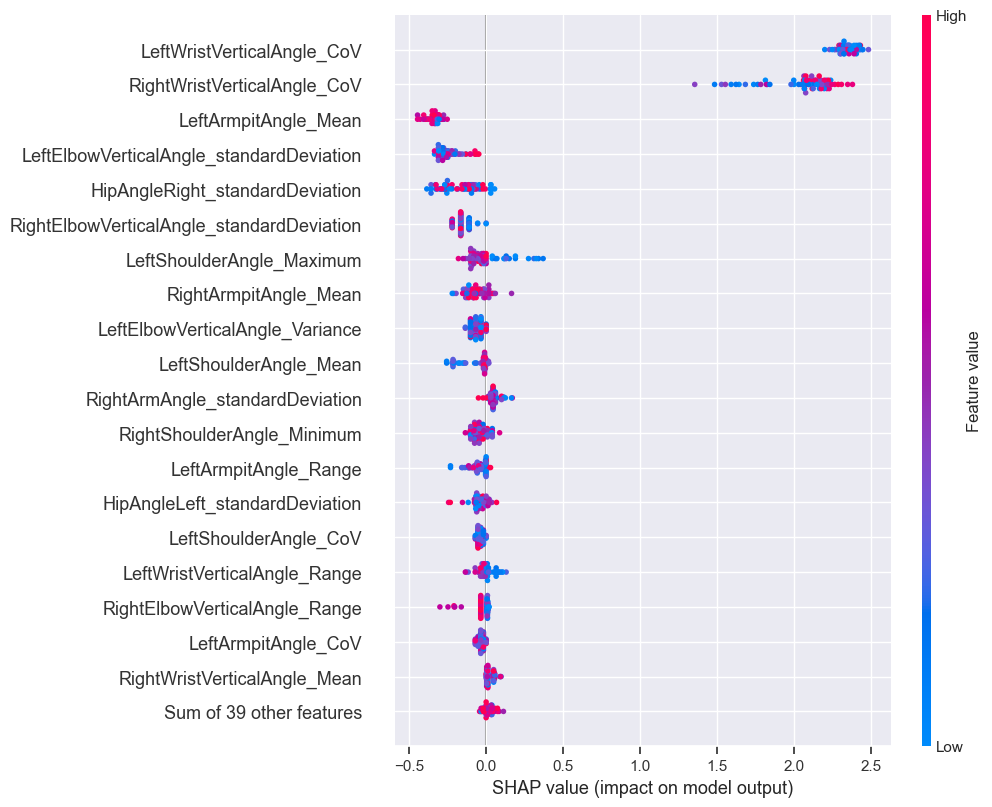

In [13]:
feature_names = train_X.columns
select_kbest = best_modelo.named_steps['feature_selection']
selected_features_mask = select_kbest.get_support()
selected_features = feature_names[selected_features_mask]

# Ensure the test data matches the selected features
df_selected = test_X[selected_features]

# df_selected = df_selected.values

classifier = best_modelo.named_steps['classifier']   

# Compute SHAP values
explainer = shap.Explainer(classifier.predict, df_selected)
shap_values = explainer(df_selected)

# To focus on specific classes (e.g., 7 and 8), you can filter the data:
y_pred = classifier.predict(df_selected)

# For class 7
class_7_mask = (y_pred == 7)
shap.plots.beeswarm(shap_values[class_7_mask], max_display=20, show=False)

# For class 8
# class_8_mask = (y_pred == 8)
# shap.plots.beeswarm(shap_values[class_8_mask], max_display=20, show=False)

In [11]:
test_X[selected_features].columns

Index(['LeftShoulderAngle_standardDeviation',
       'RightElbowVerticalAngle_standardDeviation',
       'RightArmpitAngle_standardDeviation', 'RightArmAngle_standardDeviation',
       'LeftWristVerticalAngle_standardDeviation',
       'RightWristVerticalAngle_standardDeviation',
       'LeftArmpitAngle_standardDeviation', 'HipAngleLeft_standardDeviation',
       'RightShoulderAngle_standardDeviation',
       'HipAngleRight_standardDeviation',
       'LeftElbowVerticalAngle_standardDeviation', 'LeftShoulderAngle_Maximum',
       'RightArmAngle_Maximum', 'LeftShoulderAngle_Minimum',
       'RightElbowVerticalAngle_Minimum', 'RightArmpitAngle_Minimum',
       'LeftWristVerticalAngle_Minimum', 'RightWristVerticalAngle_Minimum',
       'LeftArmpitAngle_Minimum', 'RightShoulderAngle_Minimum',
       'LeftElbowVerticalAngle_Minimum', 'LeftShoulderAngle_Mean',
       'RightElbowVerticalAngle_Mean', 'RightArmpitAngle_Mean',
       'LeftWristVerticalAngle_Mean', 'RightWristVerticalAngle_Mean',


**2.3 Guardar el pipeline**

In [12]:
# ------ Guardar el pipeline entrenado --------
filename = '../Resultados/modelo_fase1_copy.sav'
joblib.dump(best_modelo, filename)

['../Resultados/modelo_fase1_copy.sav']